### Generating human faces with Adversarial Networks (5 points)
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over the Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on https://github.com/Lasagne/Recipes/pull/94 .

In [3]:
import numpy as np


from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'axes.titlesize': 'small'})


import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid
from torch.autograd import Variable


device = torch.device("cuda")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls drive/MyDrive/celeba_data

identity_CelebA.txt   list_bbox_celeba.txt     list_landmarks_align_celeba.txt
list_attr_celeba.txt  list_eval_partition.txt  list_landmarks_celeba.txt


In [6]:
!mkdir celeba
!cp drive/MyDrive/celeba_data/* celeba
!cp -R drive/MyDrive/CelebA/Img/img_align_celeba.zip ./celeba

In [7]:
!ls celeba

identity_CelebA.txt   list_eval_partition.txt
img_align_celeba.zip  list_landmarks_align_celeba.txt
list_attr_celeba.txt  list_landmarks_celeba.txt
list_bbox_celeba.txt


In [8]:
!cd celeba && unzip -q img_align_celeba.zip && cd ..

In [ ]:
#drive.flush_and_unmount()

In [9]:
#!L
class CropCelebA64:
    
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [10]:


#!L

# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment .Grayscale :)

train_dataset = torchvision.datasets.CelebA(
    root='.',
    split='train',
    #download=True,
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Grayscale(),
        torchvision.transforms.Normalize(0.5, 0.5)
    ]),
)

In [11]:
IMG_SHAPE = tuple(train_dataset[0][0].shape)

### Prepare Dataset

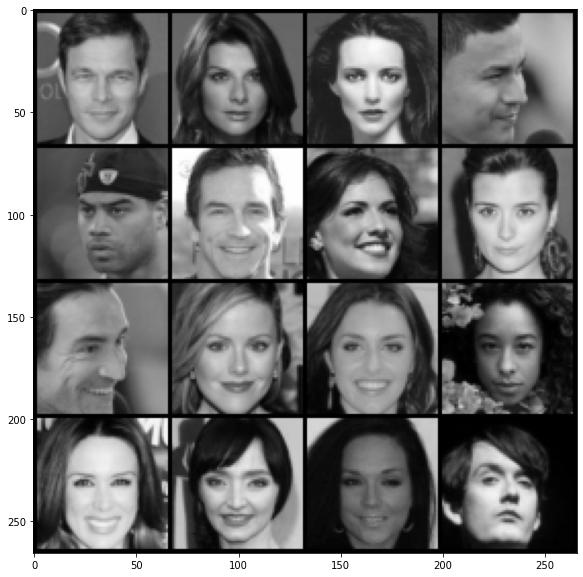

In [12]:
#!L
# print some images
samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0)

plt.figure(figsize=(10, 10))
plt.imshow(make_grid((1 + samples) / 2, nrow=4).permute(1, 2, 0))
plt.show()

max# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates a face (small image)
* make up a __measure__ of __how good this face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [13]:
MAX_VAL = 1e5;

def is_valid(tensor):
    pass
    #assert torch.sum(tensor.isnan()) == 0
    #assert torch.sum(torch.logical_or(tensor > MAX_VAL, tensor < -MAX_VAL)) == 0

In [14]:
#!L
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.to(device)
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape = shape
    
    def forward(self,input):
        return input.view(self.shape)

In [203]:
#!L
CODE_SIZE = 100 # Size of z noise vector; feel free to change it


class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()

        # TODO

        self.generator = nn.Sequential(
            nn.Linear(CODE_SIZE, 128*8*8),
            Reshape([-1, 128, 8, 8]),
            nn.BatchNorm2d(128),
            nn.ELU(),

            nn.PixelShuffle(2),
            nn.Conv2d(32, 32, kernel_size=3, padding='same', padding_mode='reflect', bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),

            nn.PixelShuffle(2),
            nn.Conv2d(8, 8, kernel_size=3, padding='same', padding_mode='reflect', bias=False),
            nn.BatchNorm2d(8),
            nn.ELU(),

            nn.PixelShuffle(2),
            nn.Conv2d(2, 1, kernel_size=3, padding='same', padding_mode='reflect', bias=False),
            nn.Tanh()

        )


    def forward(self, noise):
        return self.generator(noise)

generator = Generator().to(device)

In [157]:
noise = sample_noise_batch(100)
noise.shape

torch.Size([100, 100])

In [158]:
#!L
generated_data = generator(noise)
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE, tuple(generated_data.shape)[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [159]:
#!L
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(len(train_dataset)), size=batch_size)
    batch = torch.stack([train_dataset[idx][0] for idx in idxs], dim=0)
    return batch.to(device)

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [204]:
#!L
discriminator = nn.Sequential()

## YOUR CODE - create convolutional architecture for discriminator
## Note: please start simple. A few convolutions & poolings would do, inception/resnet is an overkill

#!L
discriminator = nn.Sequential()

# reshape from "images" to flat vectors


discriminator.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding='same'))
discriminator.add_module('norm1', nn.LayerNorm([4, 64, 64]))
discriminator.add_module('conv1_elu', nn.ELU())
discriminator.add_module('pool1', nn.AvgPool2d(2))

discriminator.add_module('conv2', nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding='same'))
discriminator.add_module('norm2', nn.LayerNorm([16, 32, 32]))
discriminator.add_module('conv2_elu', nn.ELU())
discriminator.add_module('pool2', nn.AvgPool2d(2))

discriminator.add_module('conv3', nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding='same'))
discriminator.add_module('norm3', nn.LayerNorm([64, 16, 16]))
discriminator.add_module('conv3_elu', nn.ELU())
discriminator.add_module('pool3', nn.AvgPool2d(2))


discriminator.add_module('flatten', nn.Flatten())
# dense "head"
discriminator.add_module('dense1', nn.Linear(64 * 8 * 8, 16))
discriminator.add_module('dense1_elu', nn.ELU())
discriminator.add_module('norm4', nn.LayerNorm(16))
discriminator.add_module('dense2_logits', nn.Linear(16, 1)) 
#discriminator.add_module('sigmoid', nn.Sigmoid())



discriminator.to(device)

Sequential(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm1): LayerNorm((4, 64, 64), eps=1e-05, elementwise_affine=True)
  (conv1_elu): ELU(alpha=1.0)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm2): LayerNorm((16, 32, 32), eps=1e-05, elementwise_affine=True)
  (conv2_elu): ELU(alpha=1.0)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (norm3): LayerNorm((64, 16, 16), eps=1e-05, elementwise_affine=True)
  (conv3_elu): ELU(alpha=1.0)
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=4096, out_features=16, bias=True)
  (dense1_elu): ELU(alpha=1.0)
  (norm4): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (dense2_logits): Linear(in_features=16, out_features=1, bias=True)
)

In [161]:
#!L
images = sample_data_batch(4)

In [162]:
images[0]

tensor([[[-0.4301, -0.6079, -0.4368,  ..., -0.0995, -0.1114, -0.1114],
         [-0.5670, -0.6883, -0.5707,  ..., -0.0515, -0.0524, -0.0358],
         [-0.7094, -0.7258, -0.6865,  ...,  0.0200,  0.0347,  0.0499],
         ...,
         [-0.6004, -0.4705, -0.3762,  ...,  0.9467,  0.9467,  0.9467],
         [-0.7091, -0.5800, -0.4589,  ...,  0.9310,  0.9388,  0.9467],
         [-0.8601, -0.6979, -0.5635,  ...,  0.9310,  0.9388,  0.9467]]],
       device='cuda:0')

In [163]:
predictions = discriminator(images)

In [164]:
predictions.shape

torch.Size([4, 1])

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [165]:
#!L
def generator_loss(generator, discriminator, noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(noise)
    is_valid(generated_data)

    
    disc_on_fake_data = discriminator(generated_data)
    is_valid(disc_on_fake_data)

    return -disc_on_fake_data.mean()

In [166]:
#!L
loss = generator_loss(generator, discriminator, sample_noise_batch(32))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(0.5286, device='cuda:0', grad_fn=<NegBackward0>)


In [167]:
#!L
def discriminator_loss(discriminator, real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """

    disc_on_real_data = discriminator(real_data)
    disc_on_fake_data = discriminator(generated_data)
    
    is_valid(disc_on_real_data)
    is_valid(disc_on_fake_data)

    return disc_on_fake_data.mean() - disc_on_real_data.mean()

In [168]:
#!L
loss = discriminator_loss(discriminator, 
                    sample_data_batch(32), 
                   generator(sample_noise_batch(32)))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(0.2336, device='cuda:0', grad_fn=<SubBackward0>)


In [169]:
def grad_penalty_loss(discriminator, real_data, fake_data, alpha=None):
    if alpha is None:
        alpha = torch.rand((real_data.size(0), 1, 1, 1), device=device)
    mixed_data = alpha * real_data + (1 - alpha) * fake_data
    mixed_data.requires_grad_(True)
    mixed_prediction = discriminator(mixed_data)
    grads = torch.autograd.grad(
        inputs=mixed_data, 
        outputs=mixed_prediction, 
        create_graph=True, 
        retain_graph=True,
        grad_outputs=torch.ones_like(mixed_prediction)
    )[0]
    grads = grads.view(real_data.size(0), -1)
    return torch.mean((torch.linalg.norm(grads, dim=1) - 1) ** 2)

In [170]:
real_data = sample_data_batch(32)
fake_data = generator(sample_noise_batch(32))
alpha = torch.rand((real_data.size(0), 1, 1, 1), device=device)

In [171]:
#!L
loss = grad_penalty_loss(discriminator, 
                    real_data, 
                   fake_data, alpha)

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(0.5157, device='cuda:0', grad_fn=<MeanBackward0>)


### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [33]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=9cbb57ba5c52ce6381ad650f32cc68c7249c5cf3ddb9f73f7bf9e75e24b14489
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [172]:
from sklearn.metrics import roc_auc_score

#!L
def sample_images(generator, nrow, ncol, sharp=False):
    with torch.no_grad():
        images = generator(sample_noise_batch(batch_size=nrow*ncol))
        images = images.squeeze().data.cpu().numpy()
        images = (1 + images) / 2
    if np.var(images)!=0:
        images = images.clip(0, 1)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i], cmap="gray")
    plt.show()

def sample_probas(generator, discriminator, batch_size):
    with torch.no_grad():
        D_real = torch.sigmoid(discriminator(sample_data_batch(batch_size)))
        generated_data_batch = generator(sample_noise_batch(batch_size))
        D_fake = torch.sigmoid(discriminator(generated_data_batch))

    real_scores = D_real.cpu().data.numpy()
    fake_scores = D_fake.cpu().data.numpy()
    scores = np.concatenate((real_scores, fake_scores), axis=0)
    labels = [True] * D_real.size(0) + [False] * D_fake.size(0)

    roc_auc = roc_auc_score(labels, scores)

    print(f"Discriminator ROC AUC {roc_auc:0.4f}")

    plt.title('Generated vs real data')
    plt.hist(real_scores,
            label='D(x)', alpha=0.5, range=[0,1])
    plt.hist(fake_scores,
            label='D(G(z))', alpha=0.5, range=[0,1])
    plt.legend(loc='best')
    plt.show()

Discriminator ROC AUC 0.4001


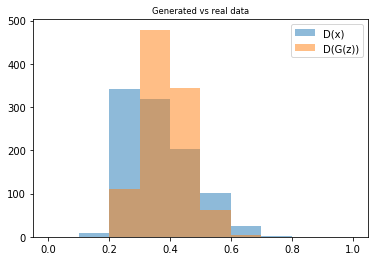

In [173]:
sample_probas(generator, discriminator, 1000)

In [174]:
def add_noise(batch, magnitude=0.2):
    return batch + magnitude * torch.randn_like(batch, device=batch.device)

In [175]:
images = sample_data_batch(4)
print(images.mean())
print(images.std())
print()
print(add_noise(images).mean())
print(add_noise(images).std())

tensor(-0.3019, device='cuda:0')
tensor(0.5118, device='cuda:0')

tensor(-0.3007, device='cuda:0')
tensor(0.5490, device='cuda:0')


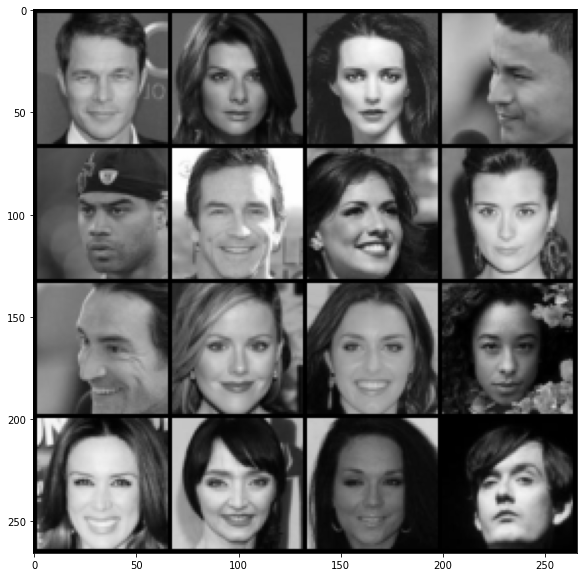

In [176]:
#!L
# print some images
samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0)

plt.figure(figsize=(10, 10))
plt.imshow(make_grid((1 + samples) / 2, nrow=4).permute(1, 2, 0))
plt.show()

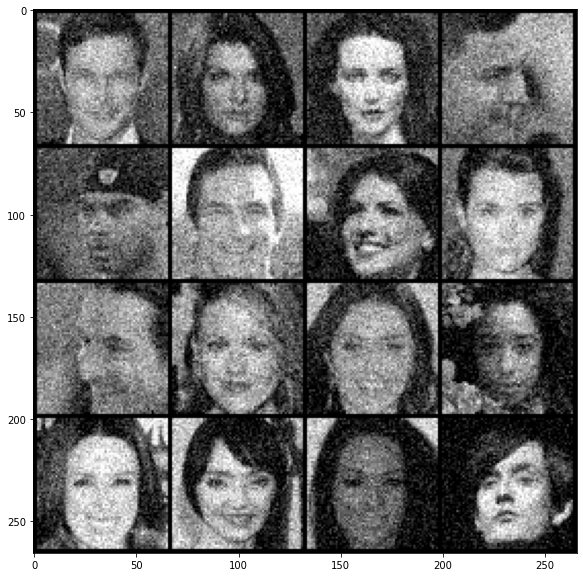

In [186]:
#!L
# print some images

samples = add_noise(torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0))

plt.figure(figsize=(10, 10))
plt.imshow(make_grid((1 + samples) / 2, nrow=4).permute(1, 2, 0))
plt.show()

In [177]:
noise_image = torch.randn((64, 1, 64, 64), device=device)

In [178]:
noise_image.shape

torch.Size([64, 1, 64, 64])

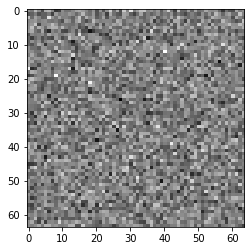

In [179]:
def show(img):
    plt.imshow(img.mean(dim=[0, 1]).cpu().data.numpy(), cmap="gray")

show(noise_image)

In [180]:
lst = [
    'conv1',
    'norm1',
    'conv1_elu',
    'pool1',

    'conv2',
    'norm2',
    'conv2_elu',
    'pool2',

    'conv3',
    'norm3',
    'conv3_elu',
    'pool3'
]

cur = sample_data_batch(100)
result = {}
for l in lst:
    cur = getattr(discriminator, l)(cur)
    result[l] = cur

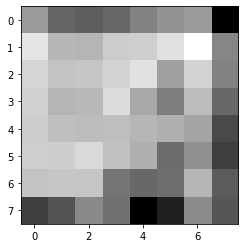

In [181]:
show(result['pool3'])

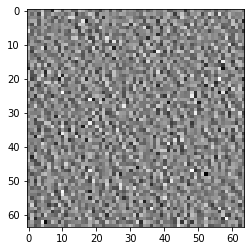

In [187]:
noise = sample_noise_batch(256)
images = generator(noise)
show(images)

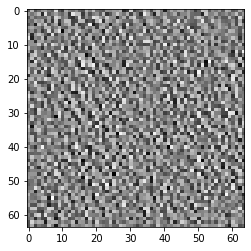

In [188]:
images = generator(sample_noise_batch(batch_size=1))
images = images.squeeze().data.cpu().numpy()
plt.imshow(images, cmap="gray", interpolation="none")

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [206]:
#!L
# optimizers
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.9))
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.9))

epoch 13
Prev epoch taken 204.9372 seconds
iteration 100 out of 635
Disc loss = -3.5323
Loss with penalty = 16.13


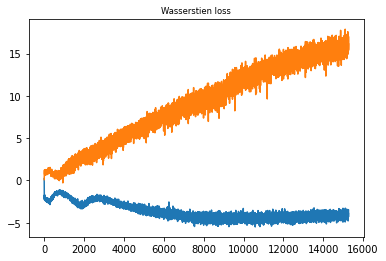

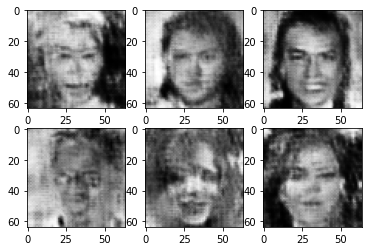

Discriminator ROC AUC 0.8818


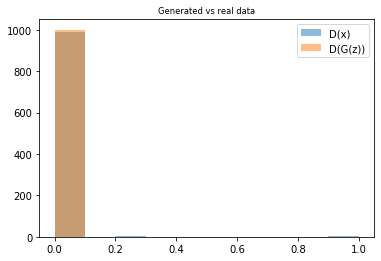

KeyboardInterrupt: ignored

In [209]:
#!L
from IPython import display
from tqdm.auto import tqdm
import time

batch_size = 256
lambda_gp = 10
ratio = 2

batches_per_epoch = len(train_dataset) // batch_size

loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

prev_epoch_time = None

#history_w_loss = []
#history_gen_loss = []
#total_iteration = 0

def get(lst, ind):
    return list(map(lambda x: x[ind], lst))

for epoch in range(25):
    start_time = time.perf_counter()
    for iteration, (batch, _) in tqdm(enumerate(loader)):

        # Train discriminator
        real_data = add_noise(batch.to(device), 0.0)
        fake_data = generator(sample_noise_batch(batch_size))
        d_loss = discriminator_loss(discriminator, real_data, fake_data)
        loss = d_loss + lambda_gp * grad_penalty_loss(discriminator, real_data, fake_data)
        disc_opt.zero_grad(set_to_none=False)
        loss.backward()
        disc_opt.step()
        
        history_w_loss.append((total_iteration, d_loss.cpu().data.numpy()))

        # Train generator
        if iteration % ratio == 0:
            noise = sample_noise_batch(batch_size)
            loss = generator_loss(generator, discriminator, noise)
            gen_opt.zero_grad(set_to_none=False)
            loss.backward()
            gen_opt.step()

            history_gen_loss.append((total_iteration, loss.cpu().data.numpy()))

        if iteration % 100 == 0:
            display.clear_output(wait=True)
            
            print("epoch {}".format(epoch))
            if prev_epoch_time:
                print(f"Prev epoch taken {prev_epoch_time:0.4f} seconds")
            print("iteration {} out of {}".format(iteration, len(train_dataset) // batch_size))
            print(f"Disc loss = {d_loss:0.4f}")
            print(f"Loss with penalty = {loss:0.4}")

            plt.title('Wasserstien loss')
            plt.plot(get(history_w_loss, 0), get(history_w_loss, 1))
            plt.plot(get(history_gen_loss, 0), get(history_gen_loss, 1))
            plt.show()

            sample_images(generator, 2,3)
            sample_probas(generator, discriminator, 1000)
        total_iteration += 1
    prev_epoch_time = time.perf_counter() - start_time
    
    
print(f"Last epoch taken {prev_epoch_time:0.4f} seconds")

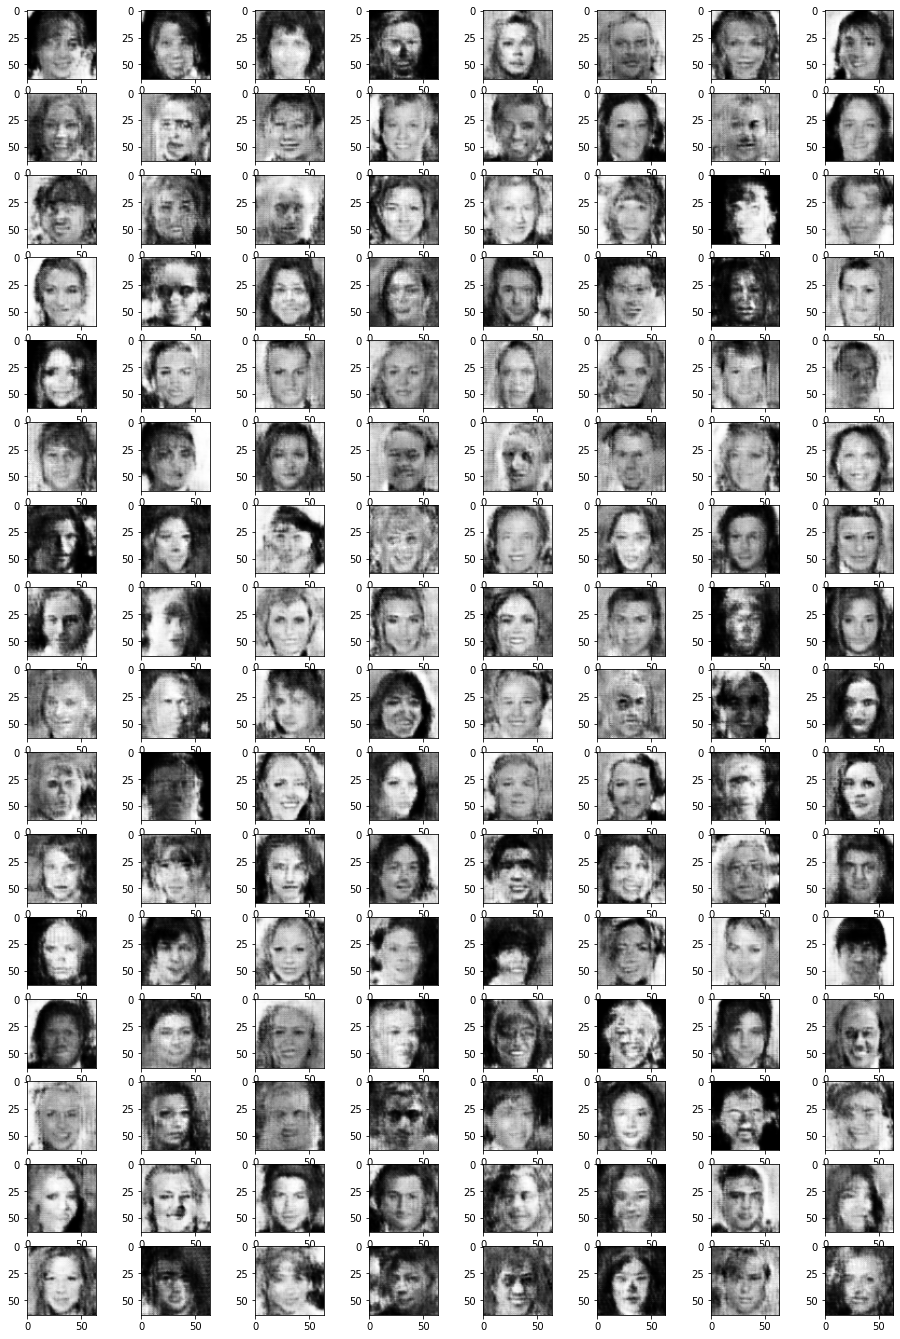

In [210]:
#!L
plt.figure(figsize=[16, 24])
sample_images(generator, 16, 8)

# Note: a no-nonsense neural network should be able to produce reasonably good images after 15k iterations
# By "reasonably good" we mean "resembling a car crash victim" or better

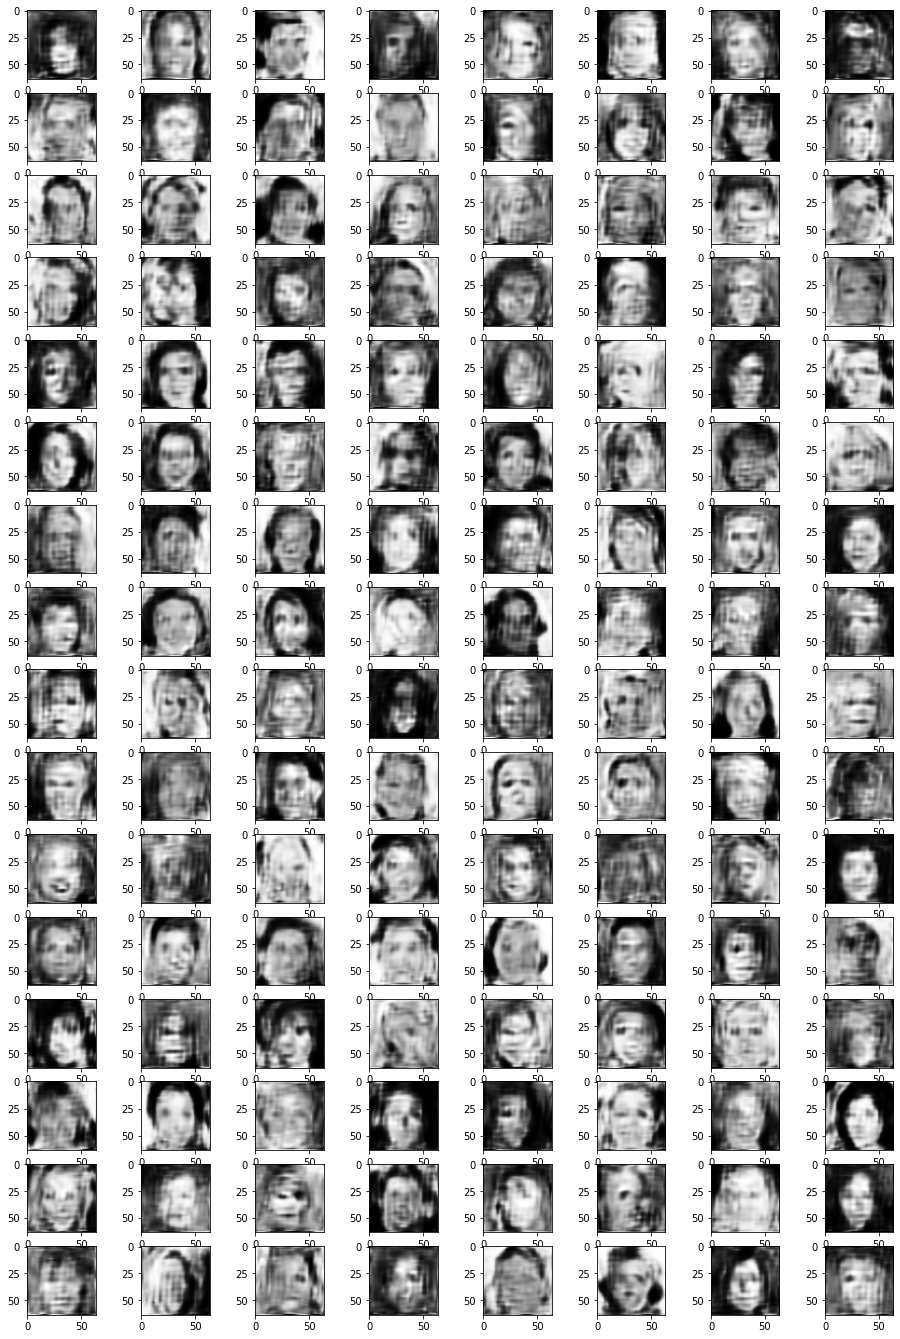

In [87]:
#!L
plt.figure(figsize=[16, 24])
sample_images(generator, 16, 8)

# Note: a no-nonsense neural network should be able to produce reasonably good images after 15k iterations
# By "reasonably good" we mean "resembling a car crash victim" or better

### Evaluation
__The code below__ dumps a batch of images so that you could use them for precision/recall evaluation.

Please generate the same number of images as for autoencoders for a fair comparison.

In [ ]:
#!L
num_images = 10000
batch_size = 100

all_images = []

for batch_i in range(int((num_images - 1) / batch_size + 1)):
    with torch.no_grad():
        images = generator(sample_noise_batch(batch_size=batch_size))
        images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(0, 1)
        
    all_images.append(images)
    
all_images = np.concatenate(all_images, axis=0)[:num_images]

np.savez("./gan.npz", Pictures=all_images)